# Xinghuan_Pdfplumber_Coding_Sample

In this coding sample, I mainly use pdfplumber package to get the data
from a pdf table without explicit lines and cells. The original pdf, 
"original_table_pdfplumber.pdf" is in the same folder with this sample. After 
scraping the data, I clean it and save the output dataframe with the name, 
"output_CWC Software, Inc..csv"

This code file has 3 parts: 
    - Part 0 Initialization 
    - Part 1 Data scraping and cleaning 
    - Part 3 Making Dataframe

### Part 0 Initialization

In [74]:
# I import needed package
# Just to clarify, because I got some problems to use pip to install ImageMagick
# package, I just installed it to my PC manually. I don't have to import it here
import os 
import pdfplumber
import pandas as pd
from datetime import datetime
import numpy as np 

# I join the file with the working directory and name the file, "scraped_pdf". 
path_scraping = os.path.join(os.getcwd(), 'original_table_pdfplumber.pdf')
scraped_pdf = pdfplumber.open(path_scraping)

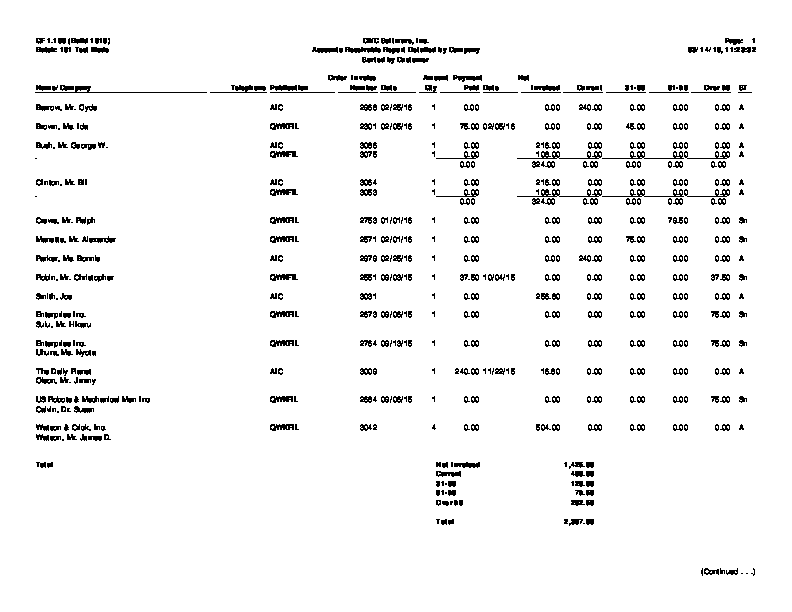

In [75]:
# I save the first page of this file as p0 (it only has one page) and transform it 
# to image, scraped_im, for later inspection. 
p0 = scraped_pdf.pages[0]
scraped_im = p0.to_image()
scraped_im

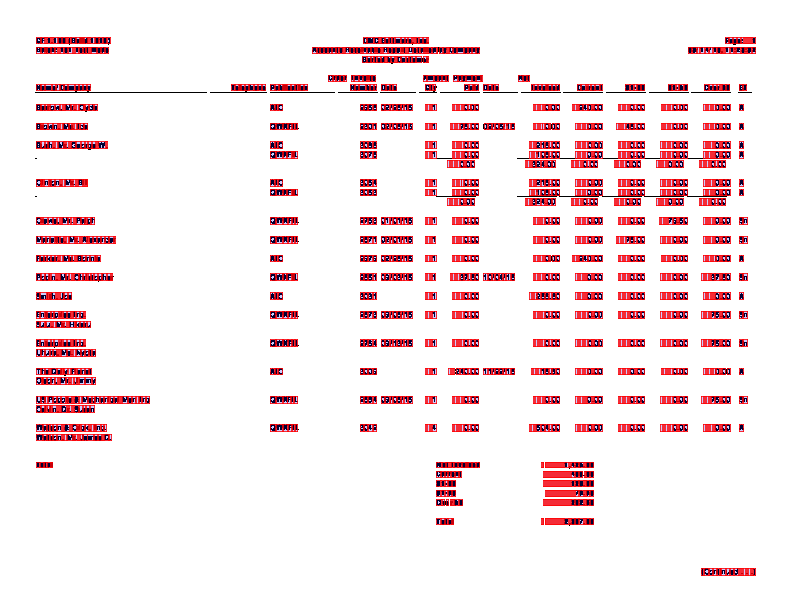

In [76]:
scraped_im.reset().draw_rects(p0.chars) # This is to see if there is white space character between columns

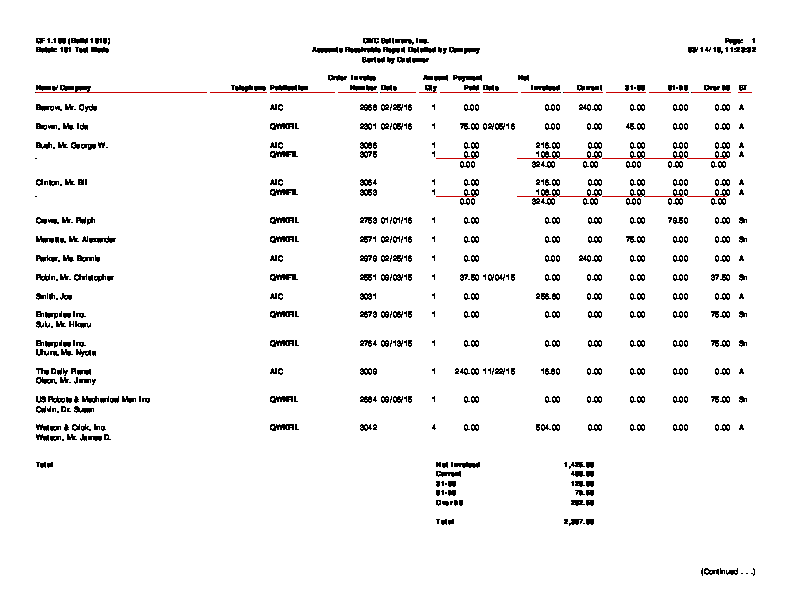

In [77]:
scraped_im.reset().debug_tablefinder() # This is to see if the default settings could correctly scrape the table

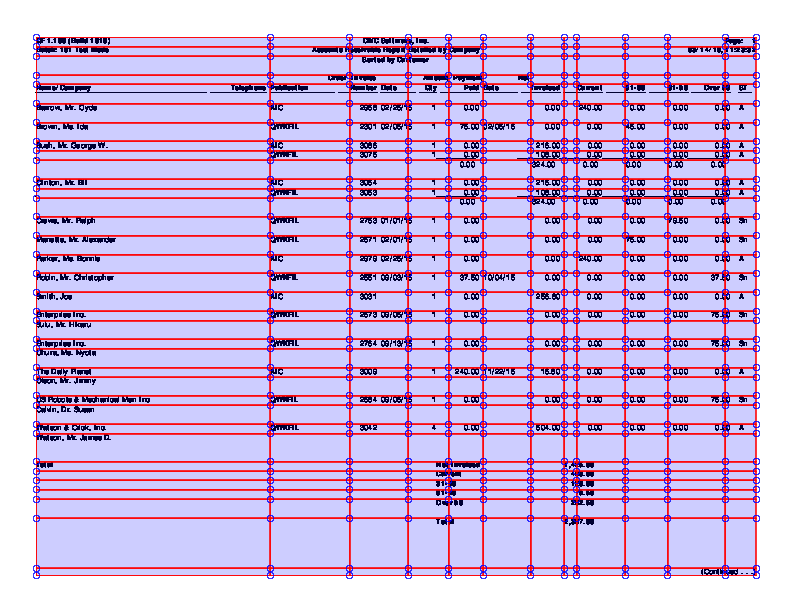

In [78]:
# Because there is no explicit lines between columns and rows, I use 'text' option below. 
table_settings = {
    "vertical_strategy": "text", 
    "horizontal_strategy": "text",
    }

scraped_im.reset().debug_tablefinder(table_settings) # This is to see if my table_settings works well on this table

In [79]:
# I scrap it. I only keep the content in the table and drop the header and footer. 
scraped_table = p0.extract_table(table_settings)
core_table = scraped_table[5:28] # Elements from 5 to 28 are the main table content
scraped_df = pd.DataFrame(core_table)
scraped_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,"Barrow, Mr. Clyde",AIC,2968 02/25/1,6 1,0.00,,0.00,,240.00,0.00,0.00 0.0,0 A
1,"Brown, Ms. Ida",QWKFIL,2301 02/05/1,6 1,75.00,02/05/16,0.00,,0.00,45.00,0.00 0.0,0 A
2,"Bush, Mr. George W.",AIC,3086,1,0.00,,216.00,,0.00,0.00,0.00 0.0,0 A
3,,QWKFIL,3075,1,0.00,,108.00,,0.00,0.00,0.00 0.0,0 A
4,,,,,0.00,,324.00,,0.00,0.00,0.00 0.00,
5,"Clinton, Mr. Bill",AIC,3064,1,0.00,,216.00,,0.00,0.00,0.00 0.0,0 A
6,,QWKFIL,3053,1,0.00,,108.00,,0.00,0.00,0.00 0.0,0 A
7,,,,,0.00,,324.00,,0.00,0.00,0.00 0.00,
8,"Crewe, Mr. Ralph",QWKFIL,2753 01/01/1,6 1,0.00,,0.00,,0.00,0.00,79.50 0.0,0 Sn
9,"Manette, Mr. Alexander",QWKFIL,2571 02/01/1,6 1,0.00,,0.00,,0.00,75.00,0.00 0.0,0 Sn


### Part 1 Data scraping and cleaning

In [80]:
# In the original pdf table, because 4 companies were acquired by other companies, 
# those 4 companies should have the same value with the company that acquired them. 
# Those 4 companies don't have any value in this table. So, I combine those 4 
# companies with the company that acquired them. 
def combine_same_rows(x): 
    """This function combines the observation of two companies 
    in which one company is acquired by another and drops 
    the observation of acquired company  """
    for row in x: 
        if row != x[-1]: 
            next_row = x[x.index(row)+1]
            if not any(next_row[1:]): 
                row[0] = row[0]+'\\'+ next_row[0]
                x.pop(x.index(next_row))
combine_same_rows(core_table)                
# Because some companies have more than one observation and there is no company's 
# name for those additional observations, I add their corresponding company name to
# to those observation. 
for row in core_table: 
    last_row = core_table[core_table.index(row)-1]
    if row[0] == '': 
        row[0] = last_row[0]
        for i in range(len(row)): 
            if row[i] == '': 
                row[i] = last_row[i]                

     
# Because these three columns, Order_Invoice_Number, Date and Amount_Qty 
# were mixed into two columns in the output, I seperate them into three columns.  
for row in core_table: 
    if len(row[2]) > 4: 
        x = row[2].split(" ")
        y = row[3].split("    ")
        z = x[1] + y[0]
        row[2:4] = [x[0], z, y[1]]
    else: 
        row.insert(3, '')
        
# Because the last three columns, 61-90, Over_90 and ST were mixed into two columns
# in the output, I seperate them into three columns. 
for row in core_table: 
    x = row[-2].split("   ")
    row[-2] = x[0]
    row.insert(-1, x[-1])
    row[-2] = row[-2].strip(" ")

for row in core_table: 
    x = row[-1].split(" ")
    row[-2] = row[-2] + x[0]
    row[-1] = x[1]             
 
# I transform all number to float type. 
for row in core_table: 
    for cell in row: 
        try: 
            row[row.index(cell)] = float(cell)
        except ValueError: 
            pass

# I transform all date to datatime type. 
for row in core_table: 
    for cell in row:
        try: 
            row[row.index(cell)] = datetime.strptime(cell, '%m/%d/%y')
        except TypeError:
            pass
        except ValueError:
            pass

# Because the name of each column are distributed into two rows, which makes it hard
# to scrape and organize, I create the column's name manually. 
COLUMNS = ['Name/Company', 
            'Telephone', 
            'Publication', 
            'Order Invoice Number', 
            'Date 1', 
            'Amount Qty', 
            'Payment Paid', 
            'Date 2', 
            'Not Invoiced', 
            'Current', 
            '31-60', 
            '61-90', 
            'Over 90', 
            'St'
    ]

scraped_df = pd.DataFrame(core_table)
scraped_df 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,"Barrow, Mr. Clyde",AIC,2968.0,2016-02-25,1.0,0.0,NaT,0.0,,240.0,0.0,0.0,0.0,A
1,"Brown, Ms. Ida",QWKFIL,2301.0,2016-02-05,1.0,75.0,2016-02-05,0.0,,0.0,45.0,0.0,0.0,A
2,"Bush, Mr. George W.",AIC,3086.0,NaT,1.0,0.0,NaT,216.0,,0.0,0.0,0.0,0.0,A
3,"Bush, Mr. George W.",QWKFIL,3075.0,NaT,1.0,0.0,NaT,108.0,,0.0,0.0,0.0,0.0,A
4,"Bush, Mr. George W.",QWKFIL,3075.0,NaT,1.0,0.0,NaT,324.0,,0.0,0.0,0.0,0.0,A
5,"Clinton, Mr. Bill",AIC,3064.0,NaT,1.0,0.0,NaT,216.0,,0.0,0.0,0.0,0.0,A
6,"Clinton, Mr. Bill",QWKFIL,3053.0,NaT,1.0,0.0,NaT,108.0,,0.0,0.0,0.0,0.0,A
7,"Clinton, Mr. Bill",QWKFIL,3053.0,NaT,1.0,0.0,NaT,324.0,,0.0,0.0,0.0,0.0,A
8,"Crewe, Mr. Ralph",QWKFIL,2753.0,2016-01-01,1.0,0.0,NaT,0.0,,0.0,0.0,79.5,0.0,Sn
9,"Manette, Mr. Alexander",QWKFIL,2571.0,2016-02-01,1.0,0.0,NaT,0.0,,0.0,75.0,0.0,0.0,Sn


### Part 3 Making Dataframe  

In [81]:
# I replace all empty value with np.nan. 
scraped_df = scraped_df.replace(r'^\s*$', np.nan, regex=True)

# I drop the additional empty column and insert one additional column for
# adding column's name. 
scraped_df.dropna(axis='columns',how='all', inplace=True)
scraped_df.insert(1,'Empty', '')
scraped_df.columns = range(14)

# I add the column's name to this dataframe and get rid of the time of each date. 
# I only keep the date, yyyy-mm-dd.
scraped_df.columns = COLUMNS
for dt in scraped_df[['Date 1', 'Date 2']]: 
    scraped_df[dt] = pd.to_datetime(scraped_df[dt]).dt.date

# I replace all empty value with np.nan. 
scraped_df = scraped_df.replace(r'^\s*$', np.nan, regex=True)
scraped_df = scraped_df.replace(pd.NaT, np.nan)

scraped_df

,Name/Company,Telephone,Publication,Order Invoice Number,Date 1,Amount Qty,Payment Paid,Date 2,Not Invoiced,Current,31-60,61-90,Over 90,St
0,"Barrow, Mr. Clyde",NaN,AIC,2968.0,2016-02-25,1.0,0.0,NaN,0.0,240.0,0.0,0.0,0.0,A
1,"Brown, Ms. Ida",NaN,QWKFIL,2301.0,2016-02-05,1.0,75.0,2016-02-05,0.0,0.0,45.0,0.0,0.0,A
2,"Bush, Mr. George W.",NaN,AIC,3086.0,NaN,1.0,0.0,NaN,216.0,0.0,0.0,0.0,0.0,A
3,"Bush, Mr. George W.",NaN,QWKFIL,3075.0,NaN,1.0,0.0,NaN,108.0,0.0,0.0,0.0,0.0,A
4,"Bush, Mr. George W.",NaN,QWKFIL,3075.0,NaN,1.0,0.0,NaN,324.0,0.0,0.0,0.0,0.0,A
5,"Clinton, Mr. Bill",NaN,AIC,3064.0,NaN,1.0,0.0,NaN,216.0,0.0,0.0,0.0,0.0,A
6,"Clinton, Mr. Bill",NaN,QWKFIL,3053.0,NaN,1.0,0.0,NaN,108.0,0.0,0.0,0.0,0.0,A
7,"Clinton, Mr. Bill",NaN,QWKFIL,3053.0,NaN,1.0,0.0,NaN,324.0,0.0,0.0,0.0,0.0,A
8,"Crewe, Mr. Ralph",NaN,QWKFIL,2753.0,2016-01-01,1.0,0.0,NaN,0.0,0.0,0.0,79.5,0.0,Sn
9,"Manette, Mr. Alexander",NaN,QWKFIL,2571.0,2016-02-01,1.0,0.0,NaN,0.0,0.0,75.0,0.0,0.0,Sn


In [83]:
# I got the name of the author of this pdf by using a bbox to scan it and save it
# as the name of this output.  
title_crop = p0.within_bbox((200, 25, 600, 45))
title_crop.to_image()

In [84]:
# I save it as the name of this output.  
title_chars = title_crop.extract_text()
scraped_df.to_csv('output_' + title_chars + '.csv')